In [ ]:
#This checks only the malicious link in the csv with the email message body.

import pandas
import win32com.client
import imaplib
import email
from email.header import decode_header
import webbrowser
import os
import sys

col_list = ["url"]
df = pandas.read_csv('malicious.csv', usecols=col_list)

# Connect to inbox
username = 'tpmpuser123@gmail.com'
password = 'Tp@mpuser999'
mail_server = 'imap.gmail.com'
imap_server = imaplib.IMAP4_SSL(host=mail_server)
imap_server.login(username, password)
imap_server.select('INBOX')  # Default is `INBOX`

search_criteria = 'ALL'
charset = None  # All
respose_code, message_numbers_raw = imap_server.search(charset, search_criteria)
message_numbers = message_numbers_raw[0].split()

# Fetch full message based on the message numbers obtained from search
for message_number in message_numbers:
    response_code, message_data = imap_server.fetch(message_number, '(RFC822)')
    for response in message_data:
        #print(response)
        if isinstance(response, tuple):
            # parse a bytes email into a message object
            msg = email.message_from_bytes(response[1])
            # decode the email subject
            subject, encoding = decode_header(msg["Subject"])[0]
            if isinstance(subject, bytes):
                # if it's a bytes, decode to str
                subject = subject.decode(encoding)
            From, encoding = decode_header(msg.get("From"))[0]
            if isinstance(From, bytes):
                From = From.decode(encoding)
            # if the email message is multipart
            if msg.is_multipart():
                # iterate over email parts
                for part in msg.walk():
                    # extract content type of email
                    content_type = part.get_content_type()
                    content_disposition = str(part.get("Content-Disposition"))
                    try:
                        # get the email body
                        body = part.get_payload(decode=True).decode()
                        for link in df["url"]:
                            for letters in body.split():
                                if link == letters:
                                    imap_server.create('malicious')
                                    imap_server.store(message_number, '+X-GM-LABELS', 'malicious')
                                    imap_server.store(message_number, '+FLAGS', '\Deleted')  # Mark as read
                                    imap_server.store(message_number, '-FLAGS', '\Deleted')  # Mark as unread
                                    imap_server.expunge()
                                    print("Subject:", subject)
                                    print("From:", From)
                                    print("Found email with malicious link!")
                                    print("Malicious link:", letters)
                                    print("")
                                else:
                                    continue
                    except:
                        pass
imap_server.close()
imap_server.logout()

#This script runs the .csv file which contains all the malicious and phishing websites against the email message body by
#checking every words in the body. The, if there is a link that appears in the body and same as the csv file, it will
#move the email to the malicious folder/label and delete the mail from inbox and expunge it. This is a little bit buggy
#however, it works if there is a malicious link that can be found in the csv file. just need to run again.

In [ ]:
# This checks Received-SPF(Sender Policy Framework) and check malicious link with the csv to the message body.
#Excluding VirusTotal and Whois domain

import pandas
import win32com.client
import imaplib
import email
from email.header import decode_header
import webbrowser
import os
import sys
import whois
import requests
import time
import json

col_list = ["url"]
df = pandas.read_csv('malicious.csv', usecols=col_list)

# Connect to inbox
username = 'tpmpuser123@gmail.com'
password = 'Tp@mpuser999'
mail_server = 'imap.gmail.com'
imap_server = imaplib.IMAP4_SSL(host=mail_server)
imap_server.login(username, password)
imap_server.select('Inbox')  # Default is `INBOX`

search_criteria = 'ALL'
charset = None  # All
respose_code, message_numbers_raw = imap_server.search(charset, search_criteria)
message_numbers = message_numbers_raw[0].split()

# Fetch full message based on the message numbers obtained from search
for message_number in message_numbers:
    response_code, message_data = imap_server.fetch(message_number, '(RFC822)')
    for response in message_data:
        #print(response)
        if isinstance(response, tuple):
            # parse a bytes email into a message object
            msg = email.message_from_bytes(response[1])
            subject = msg.get("Subject", None)
            getFrom = msg.get("From", None)
            #getFrom = getFrom.split()
            #getFrom = getFrom[-1].strip('<>')
            returnPath = msg.get("Return-Path", None)
            returnPath = returnPath.strip('<>')
            receivedSPF = msg.get("Received-SPF", None).split()
            # if the email message is multipart
            if msg.is_multipart():
                # iterate over email parts
                for part in msg.walk():
                    # extract content type of email
                    content_type = part.get_content_type()
                    content_disposition = str(part.get("Content-Disposition"))
                    try:
                        # get the email body
                        body = part.get_payload(decode=True).decode()
                        for link in df["url"]:
                            for letters in body.split():
                                if link == letters:
                                    checkIP = whois.whois(link)
                                    test = checkIP.get("domain_name", None)
                                    imap_server.create('malicious')
                                    imap_server.store(message_number, '+X-GM-LABELS', 'malicious')
                                    imap_server.store(message_number, '+FLAGS', '\Deleted')  # read mail remove from inbox
                                    imap_server.store(message_number, '-FLAGS', '\Deleted')  # unread mail remove from inbox
                                    imap_server.expunge()
                                    print(message_number)
                                    print("Subject:", subject)
                                    print("From:", getFrom)
                                    print("Domain name maybe malicious:", test, ". Check with virustotal.com")
                                    print("Found email with malicious link!")
                                    print("Malicious link:", letters)
                                    print("")
                                elif receivedSPF[0] != "pass":
                                    imap_server.create('malicious')
                                    imap_server.store(message_number, '+X-GM-LABELS', 'malicious')
                                    imap_server.store(message_number, '+FLAGS', '\Deleted')  # read mail remove from inbox
                                    imap_server.store(message_number, '-FLAGS', '\Deleted')  # unread mail remove from inbox
                                    imap_server.expunge()
                                    print(message_number)
                                    print("Subject:", subject)
                                    print("From:", getFrom)
                                    print("SPF Status:", receivedSPF[0], ". Not secure.")
                                else:
                                    continue
                    except:
                        pass
                    
imap_server.close()
imap_server.logout()

#This script runs the .csv file which contains all the malicious and phishing websites against the email message body by
#checking every words in the body. The, if there is a link that appears in the body and same as the csv file, it will
#move the email to the malicious folder/label and delete the mail from inbox and expunge it. This is a little bit buggy
#however, it works if there is a malicious link that can be found in the csv file. just need to run again.

In [ ]:
# This checks Received-SPF(Sender Policy Framework) and check malicious link with the csv to the message body.
# This includes VirusTotal API and Whois domain lookup

import pandas
import win32com.client
import imaplib
import email
from email.header import decode_header
import webbrowser
import os
import sys
import whois
import requests
import time
import json

col_list = ["url"]
df = pandas.read_csv('malicious.csv', usecols=col_list)

API_key = '9a620234276d322d185e00b59e25242ec06464b994c556d392d2ded861f2e9fe'
url = 'https://www.virustotal.com/vtapi/v2/url/report'
parameters = {'apikey': API_key, 'resource': df}
response= requests.get(url=url, params=parameters)
json_response= json.loads(response.text)

# Connect to inbox
username = 'tpmpuser123@gmail.com'
password = 'Tp@mpuser999'
mail_server = 'imap.gmail.com'
imap_server = imaplib.IMAP4_SSL(host=mail_server)
imap_server.login(username, password)
imap_server.select('Inbox')  # Default is `INBOX`

search_criteria = 'ALL'
charset = None  # All
respose_code, message_numbers_raw = imap_server.search(charset, search_criteria)
message_numbers = message_numbers_raw[0].split()

# Fetch full message based on the message numbers obtained from search
for message_number in message_numbers:
    response_code, message_data = imap_server.fetch(message_number, '(RFC822)')
    for response in message_data:
        #print(response)
        if isinstance(response, tuple):
            # parse a bytes email into a message object
            msg = email.message_from_bytes(response[1])
            subject = msg.get("Subject", None)
            getFrom = msg.get("From", None)
            #getFrom = getFrom.split()
            #getFrom = getFrom[-1].strip('<>')
            returnPath = msg.get("Return-Path", None)
            returnPath = returnPath.strip('<>')
            receivedSPF = msg.get("Received-SPF", None).split()
            # if the email message is multipart
            if msg.is_multipart():
                # iterate over email parts
                for part in msg.walk():
                    # extract content type of email
                    content_type = part.get_content_type()
                    content_disposition = str(part.get("Content-Disposition"))
                    try:
                        # get the email body
                        body = part.get_payload(decode=True).decode()
                        for link in df["url"]:
                            for letters in body.split():
                                if link == letters:
                                    parameters = {'apikey': API_key, 'resource': link} #VirusTotal only can check each link
                                    response= requests.get(url=url, params=parameters) # 4 times per minute!
                                    json_response = json.loads(response.text)
                                    if json_response['response_code'] <= 0:
                                        getstatus = "empty"
                                    elif json_response['response_code'] >= 1:
                                        if json_response['positives'] <= 0:
                                            getstatus = "positive"
                                        else:
                                            getstatus = "malicious"
                                            print(link)
                                            print("This link above is malicious according to VirusTotal!")
                                            print("")
                                    elif getstatus == "malicious":
                                        checkIP = whois.whois(link)
                                        test = checkIP.get("domain_name", None)
                                        imap_server.create('malicious')
                                        imap_server.store(message_number, '+X-GM-LABELS', 'malicious')
                                        imap_server.store(message_number, '+FLAGS', '\Deleted')  # read mail remove from inbox
                                        imap_server.expunge()
                                        print("Subject:", subject)
                                        print("From:", getFrom)
                                        print("Domain name that is malicious:", test)
                                        print("Found email with malicious link!")
                                        print("Malicious link:", letters)
                                        print("")
                                elif receivedSPF[0] != "pass":
                                    imap_server.create('malicious')
                                    imap_server.store(message_number, '+X-GM-LABELS', 'malicious')
                                    imap_server.store(message_number, '+FLAGS', '\Deleted')  # read mail remove from inbox
                                    imap_server.expunge()
                                    print("Subject:", subject)
                                    print("From:", getFrom)
                                    print("SPF Status:", receivedSPF[0], ". Not secure.")
                                else:
                                    continue
                    except:
                        pass
                    
imap_server.close()
imap_server.logout()

#This script runs the .csv file which contains all the malicious and phishing websites against the email message body by
#checking every words in the body. The, if there is a link that appears in the body and same as the csv file, it will
#move the email to the malicious folder/label and delete the mail from inbox and expunge it. It uses VirusTotal to double check
#the link if it is malicious and uses Whois domain lookup to look for the domain. However, this is a little bit buggy, meaning
#it searches the email message body for malicious link but slim chance of missing it. In addition, if it found malicious link
#and scans with the VirusTotal, it sometimes will not move the email to the malicious label. Moreover, VirusTotal only allows
#us to scan 4 links every minute. Thus, it works if there is a malicious link that can be found in the csv file and VirusTotal.
# It just needs to run again and again.

In [ ]:
# This checks Received-SPF(Sender Policy Framework) and check malicious link with the csv to the message body.
# This includes VirusTotal API and Whois domain lookup

import pandas
import win32com.client
import imaplib
import email
from email.header import decode_header
import webbrowser
import os
import sys
import whois
import requests
import time
import json
import datetime
import pytz
import numpy as np
import matplotlib.pyplot as plt

timenow = datetime.datetime.now(pytz.timezone('Asia/Singapore'))
numberofcountedmail = 0

col_list = ["url"]
df = pandas.read_csv('malicious.csv', usecols=col_list)

API_key = '9a620234276d322d185e00b59e25242ec06464b994c556d392d2ded861f2e9fe'
url = 'https://www.virustotal.com/vtapi/v2/url/report'
parameters = {'apikey': API_key, 'resource': df}
response= requests.get(url=url, params=parameters)
json_response= json.loads(response.text)

# Connect to inbox
username = 'tpmpuser123@gmail.com'
password = 'Tp@mpuser999'
mail_server = 'imap.gmail.com'
imap_server = imaplib.IMAP4_SSL(host=mail_server)
imap_server.login(username, password)
imap_server.select('Inbox')  # Default is `INBOX`

search_criteria = 'ALL'
charset = None  # All
respose_code, message_numbers_raw = imap_server.search(charset, search_criteria)
message_numbers = message_numbers_raw[0].split()

# Fetch full message based on the message numbers obtained from search
for message_number in message_numbers:
    response_code, message_data = imap_server.fetch(message_number, '(RFC822)')
    for response in message_data:
        if isinstance(response, tuple):
            # parse a bytes email into a message object
            msg = email.message_from_bytes(response[1])
            subject = msg.get("Subject", None)
            getFrom = msg.get("From", None)
            #getFrom = getFrom.split()
            #getFrom = getFrom[-1].strip('<>')
            returnPath = msg.get("Return-Path", None)
            returnPath = returnPath.strip('<>')
            receivedSPF = msg.get("Received-SPF", None).split()
            
            emptystr = []
            
            # if the email message is multipart
            if msg.is_multipart():
                # iterate over email parts
                for part in msg.walk():
                    # extract content type of email
                    content_type = part.get_content_type()
                    content_disposition = str(part.get("Content-Disposition"))
                    try:
                        # get the email body
                        body = part.get_payload(decode=True).decode()
                        for link in df["url"]:
                            for letters in body.split():
                                if link == letters:
                                    parameters = {'apikey': API_key, 'resource': link} #VirusTotal only can check each link
                                    response= requests.get(url=url, params=parameters) # 4 times per minute!
                                    json_response = json.loads(response.text)
                                    if json_response['response_code'] <= 0:
                                        getstatus = "empty"
                                    elif json_response['response_code'] >= 1:
                                        if json_response['positives'] <= 0:
                                            getstatus = "positive"
                                        else:
                                            getstatus = "malicious"
                                            emptystr.append(message_number)
                                            print(emptystr)
                                            print(link)
                                            print("This link above is malicious according to VirusTotal!")
                                            print("")
                                            numberofcountedmail += 1
                                            for everyID in emptystr:
                                                checkIP = whois.whois(link)
                                                test = checkIP.get("domain_name", None)
                                                imap_server.store(everyID, '+X-GM-LABELS', 'malicious')
                                                imap_server.store(everyID, '+FLAGS', '\Deleted')  # read mail remove from inbox
                                                imap_server.expunge()
                                                print(message_number.decode('utf-8'))
                                                print("Subject:", subject)
                                                print("From:", getFrom)
                                                print("Domain name that is malicious:", test)
                                                print("Found email with malicious link!")
                                                print("Malicious link:", letters)
                                                print("")
                                    elif receivedSPF[0] != "pass":
                                        imap_server.create('malicious')
                                        imap_server.store(message_number, '+X-GM-LABELS', 'malicious')
                                        imap_server.store(message_number, '+FLAGS', '\Deleted')  # read mail remove from inbox
                                        imap_server.expunge()
                                        print("Subject:", subject)
                                        print("From:", getFrom)
                                        print("SPF Status:", receivedSPF[0], ". Not secure.")
                                else:
                                    continue
                    except:
                        pass                    

#Start of the codes for the graph                    
scanResult = []
scannedEmails = numberofcountedmail
dateAndTimeNow = timenow.strftime('%Y-%m-%d %H:%M:%S')
scanneddata = [scannedEmails, dateAndTimeNow]
scanResult.append(scanneddata)
df2 = pandas.DataFrame(scanResult, columns = ['numberscan', 'dnt'])
print(df2)
df2.to_csv("scanemail.csv", mode = 'a', header = False, index = False)

df2headers = ['numberscan', 'dnt']
readdf2 = pandas.read_csv("scanemail.csv", usecols=df2headers)
x = readdf2['dnt']
y = readdf2['numberscan']

font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':15}

plt.title("Scan summary", fontdict = font1)
plt.xlabel("Date and Time", fontdict = font2)
plt.ylabel("No. of malicious emails found", fontdict = font2)
plt.locator_params(axis="both", integer=True, tight=True)

# plot
plt.plot(x,y)
# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.show()
#End of codes for the graph

imap_server.close()
imap_server.logout()

#This script runs the .csv file which contains all the malicious and phishing websites against the email message body by
#checking every words in the body. The, if there is a link that appears in the body and same as the csv file, it will
#move the email to the malicious folder/label and delete the mail from inbox and expunge it. It uses VirusTotal to double check
#the link if it is malicious and uses Whois domain lookup to look for the domain. However, this is a little bit buggy, meaning
#it searches the email message body for malicious link but slim chance of missing it. In addition, if it found malicious link
#and scans with the VirusTotal, it sometimes will not move the email to the malicious label. Moreover, VirusTotal only allows
#us to scan 4 links every minute. Thus, it works if there is a malicious link that can be found in the csv file and VirusTotal.
# It just needs to run again and again. 

In [ ]:
from collections import UserList
import tkinter as tk
from tkinter import *
from tkinter import ttk
from tkinter.constants import END, W
import pandas
import win32com.client
import imaplib
import email
from email.header import decode_header
import webbrowser
import os
import sys
import requests
import time
import json
#from tldextract import tldextract
#import joblib
#import pyfiglet
import datetime
import pytz
import numpy as np
import matplotlib.pyplot as plt

timenow = datetime.datetime.now(pytz.timezone('Asia/Singapore'))

col_list = ["url"]
df = pandas.read_csv('malicious.csv', usecols=col_list)

API_key = '9a620234276d322d185e00b59e25242ec06464b994c556d392d2ded861f2e9fe'
url = 'https://www.virustotal.com/vtapi/v2/url/report'
parameters = {'apikey': API_key, 'resource': df}
response= requests.get(url=url, params=parameters)
json_response= json.loads(response.text)

# Connect to inbox
username = 'tpmpuser123@gmail.com'
password = 'Tp@mpuser999'
mail_server = 'imap.gmail.com'
imap_server = imaplib.IMAP4_SSL(host=mail_server)
imap_server.login(username, password)
imap_server.select('Inbox')  # Default is `INBOX`

search_criteria = 'ALL'
charset = None  # All
respose_code, message_numbers_raw = imap_server.search(charset, search_criteria)
message_numbers = message_numbers_raw[0].split()


class Application(tk.Frame):
    def __init__(self, master=None):
        super().__init__(master)
        self.master = master
        self.pack()        
        self.create_widgets()

    def create_widgets(self):
        paddings = {'padx': 5, 'pady': 5 }
        self.fullEmailScanner = tk.Button(self,**paddings)
        self.fullEmailScanner["text"]= "Scan Full Email"
        self.fullEmailScanner["command"] = self.onload
        self.fullEmailScanner.grid(column=0 ,row=1)

        self.urlScanner = tk.Button(self,**paddings)
        self.urlScanner["text"]= "Scan URL Only"
        self.urlScanner["command"] = self.scanner
        self.urlScanner.grid(column=1 ,row=1)

        self.quit = tk.Button(self, text="QUIT", fg="red",command=self.master.destroy,**paddings)
        self.quit.grid(column=2 ,row= 1)       

    def onload(self):
        newWindow = tk.Toplevel(root)
        newWindow.geometry('700x300')
        newWindow.title("KoiScanner Results")
        maliciouslinks= tk.Listbox(newWindow,width=100,height=20)
        paddings = {'padx': 5, 'pady': 5}
        numberofcountedmail = 0
        for message_number in message_numbers:
            response_code, message_data = imap_server.fetch(message_number, '(RFC822)')
            for response in message_data:
                #print(response)
                if isinstance(response, tuple):
                    # parse a bytes email into a message object
                    msg = email.message_from_bytes(response[1])
                    subject = msg.get("Subject", None)
                    getFrom = msg.get("From", None)
                    getTo = msg.get("To", None)
                    getDate = msg.get("Date", None)
                    getID = msg.get("Message-ID", None)
                    getSPF = msg.get("Received-SPF", None)
                    #getFrom = getFrom.split()
                    #getFrom = getFrom[-1].strip('<>')
                    returnPath = msg.get("Return-Path", None)
                    returnPath = returnPath.strip('<>')
                    receivedSPF = msg.get("Received-SPF", None).split()
                    
                    # iterate over email parts
                    for part in msg.walk():
                        # extract content type of email
                        content_type = part.get_content_type()
                        content_disposition = str(part.get("Content-Disposition"))
                        try:
                            # get the email body
                            body = part.get_payload(decode=True).decode()
                            for link in df["url"]:
                                for letters in body.split():
                                    if link == letters:
                                        parameters = {'apikey': API_key, 'resource': link} #VirusTotal only can check each link
                                        response= requests.get(url=url, params=parameters) # 4 times per minute!
                                        json_response = json.loads(response.text)
                                        if json_response['response_code'] <= 0:
                                            getstatus = "empty"
                                        elif json_response['response_code'] >= 1:
                                            if json_response['positives'] <= 0:
                                                getstatus = "positive"
                                            else:
                                                maliciousemaildict = {
                                                "Message-ID:": getID,
                                                "SPF:": getSPF,
                                                "Subject:": subject,
                                                "From:": getFrom,
                                                "To:": getTo,
                                                "Date:": getDate,
                                                "Malicious-link:": letters,
                                                "===========================": "="
                                                }
                                                for key1, value1 in maliciousemaildict.items(): 
                                                    maliciousemaildictprint = (key1, value1)
                                                    maliciouslinks.insert(END,maliciousemaildictprint)
                                                imap_server.create('malicious')
                                                imap_server.store(message_number, '+X-GM-LABELS', 'malicious')
                                                imap_server.store(message_number, '+FLAGS', '\Deleted')  # read mail remove from inbox
                                                imap_server.expunge() 
                                                numberofcountedmail += 1
                                    elif receivedSPF[0] != "pass":
                                        imap_server.create('malicious')
                                        imap_server.store(message_number, '+X-GM-LABELS', 'malicious')
                                        imap_server.store(message_number, '+FLAGS', '\Deleted')  # read mail remove from inbox
                                        imap_server.expunge()
                                        print("Subject:", subject)
                                        print("From:", getFrom)
                                        print("SPF Status:", receivedSPF[0], ". Not secure.")
                                    else:
                                        continue

                        except:
                            pass
                        
        #Start of the codes for the graph                    
        scanResult = []
        scannedEmails = numberofcountedmail
        dateAndTimeNow = timenow.strftime('%Y-%m-%d %H:%M:%S')
        scanneddata = [scannedEmails, dateAndTimeNow]
        scanResult.append(scanneddata)
        df2 = pandas.DataFrame(scanResult, columns = ['numberscan', 'dnt'])
        print(df2)
        df2.to_csv("scanemail.csv", mode = 'a', header = False, index = False)

        df2headers = ['numberscan', 'dnt']
        readdf2 = pandas.read_csv("scanemail.csv", usecols=df2headers)
        x = readdf2['dnt']
        y = readdf2['numberscan']

        font1 = {'family':'serif','color':'blue','size':20}
        font2 = {'family':'serif','color':'darkred','size':15}

        plt.title("Scan summary", fontdict = font1)
        plt.xlabel("Date and Time", fontdict = font2)
        plt.ylabel("No. of malicious emails found", fontdict = font2)
        plt.locator_params(axis="both", integer=True, tight=True)

        # plot
        plt.plot(x,y)
        # beautify the x-labels
        plt.gcf().autofmt_xdate()
        plt.show()
        #End of codes for the graph            
        
        Displaytext2 = tk.Label(newWindow, text="The Following Links are malicious according to VirusTotal !",**paddings)
        Displaytext2.pack()
        maliciouslinks.pack()       

        imap_server.close()
        imap_server.logout()

    def scanner(self):
        
        newWindow2 = tk.Toplevel(root)
        newWindow2.geometry('400x230')
        newWindow2.title("KoiScanner for URL Link")

        def scan_url():
            results_scanner = "False"

            urltoscan = user_input.get()
            for link in df["url"]:
                for letters in urltoscan.split():
                    if link == letters:
                        parameters = {'apikey': API_key, 'resource': link} #VirusTotal only can check each link
                        response= requests.get(url=url, params=parameters) # 4 times per minute!
                        json_response = json.loads(response.text)
                        if json_response['response_code'] <= 0:
                            getstatus = "empty"
                        elif json_response['response_code'] >= 1:
                            if json_response['positives'] <= 0:
                                getstatus = "positive"
                            else:
                                getstatus = "malicious"
                                if getstatus == "malicious":
                                    results_scanner="True"

            newWindow3 = tk.Toplevel(newWindow2)
            newWindow3.geometry('400x230')
            newWindow3.title("KoiScanner for URL Link RESULTS")

            if results_scanner == "True":
                tk.Label(newWindow3, text="The Link IS Malicious").pack()
            else:
                tk.Label(newWindow3, text="The Link is NOT Malicious").pack()
            tk.Button(newWindow3, text="QUIT", fg="red",command=newWindow3.destroy).pack()

        tk.Label(newWindow2, text="Please Enter the Link Below!").pack()
        user_input = tk.StringVar(newWindow2)
        entry = tk.Entry(newWindow2, textvariable=user_input).pack()
        button1 = tk.Button(newWindow2,text='Scan the URL', command=scan_url).pack()
        
        tk.Button(newWindow2, text="QUIT", fg="red",command=newWindow2.destroy).pack()
        

    def exit(self):
        root.destroy()


root = tk.Tk()
root.title("KoiScanner")
root.geometry('400x230')
#bg = tk.PhotoImage(file = "D:/School Stuff/STI/KoiScanner/images/title_logo2.png")
#canvas1 = tk.Canvas( root, width = 300, height = 100)  
#canvas1.pack(fill = "both", expand = True)
#canvas1.create_image( 0, 0, image = bg,anchor = "nw")


app = Application(master=root)
app.mainloop()

In [1]:
#This is used to test the table format in tkinker
from collections import UserList
import tkinter as tk
from tkinter import ttk
from tkinter import *
from tkinter.constants import END, W
import pandas
import win32com.client
import imaplib
import email
from email.header import decode_header
import webbrowser
import os
import sys
import requests
import time
import json
#from tldextract import tldextract
#import joblib
#import pyfiglet
import datetime
import pytz
import numpy as np
import matplotlib.pyplot as plt
import re

timenow = datetime.datetime.now(pytz.timezone('Asia/Singapore'))

col_list = ["url"]
df = pandas.read_csv('malicious.csv', usecols=col_list)

API_key = '9a620234276d322d185e00b59e25242ec06464b994c556d392d2ded861f2e9fe'
url = 'https://www.virustotal.com/vtapi/v2/url/report'
parameters = {'apikey': API_key, 'resource': df}
response= requests.get(url=url, params=parameters)
json_response= json.loads(response.text)

# Connect to inbox
username = 'tpmpuser123@gmail.com'
password = 'Tp@mpuser999'
mail_server = 'imap.gmail.com'
imap_server = imaplib.IMAP4_SSL(host=mail_server)
imap_server.login(username, password)
imap_server.select('Inbox')  # Default is `INBOX`

search_criteria = 'ALL'
charset = None  # All
respose_code, message_numbers_raw = imap_server.search(charset, search_criteria)
message_numbers = message_numbers_raw[0].split()


class Application(tk.Frame):
    def __init__(self, master=None):
        super().__init__(master)
        self.master = master
        self.pack()        
        self.create_widgets()

    def create_widgets(self):
        paddings = {'padx': 5, 'pady': 5 }
        self.fullEmailScanner = tk.Button(self,**paddings)
        self.fullEmailScanner["text"]= "Scan Full Email"
        self.fullEmailScanner["command"] = self.onload
        self.fullEmailScanner.grid(column=0 ,row=1)

        self.urlScanner = tk.Button(self,**paddings)
        self.urlScanner["text"]= "Scan URL Only"
        self.urlScanner["command"] = self.scanner
        self.urlScanner.grid(column=1 ,row=1)

        self.quit = tk.Button(self, text="QUIT", fg="red",command=self.master.destroy,**paddings)
        self.quit.grid(column=3 ,row= 1)       

    def onload(self):
        newWindow = tk.Toplevel(root)
        newWindow.geometry('700x400')
        newWindow.title("KoiScanner Results")
        maliciouslinks= tk.Listbox(newWindow,width=100,height=20)
        paddings = {'padx': 5, 'pady': 5}
        numberofcountedmail = 0
        for message_number in message_numbers:
            response_code, message_data = imap_server.fetch(message_number, '(RFC822)')
            for response in message_data:
                #print(response)
                if isinstance(response, tuple):
                    # parse a bytes email into a message object
                    msg = email.message_from_bytes(response[1])
                    subject = msg.get("Subject", None)
                    getFrom = msg.get("From", None)
                    getTo = msg.get("To", None)
                    getDate = msg.get("Date", None)
                    getID = msg.get("Message-ID", None)
                    getSPF = msg.get("Received-SPF", None)
                    getSPFIP = re.search(r"(?:(?:1\d\d|2[0-5][0-5]|2[0-4]\d|0?[1-9]\d|0?0?\d)\.){3}(?:1\d\d|2[0-5][0-5]|2[0-4]\d|0?[1-9]\d|0?0?\d)", getSPF)
                    try:
                        getSPFIPmatch = getSPFIP[0]
                    except TypeError:
                        pass    
                    #getFrom = getFrom.split()
                    #getFrom = getFrom[-1].strip('<>')
                    returnPath = msg.get("Return-Path", None)
                    returnPath = returnPath.strip('<>')
                    receivedSPF = msg.get("Received-SPF", None).split()
                    
                    # if the email message is multipart
                    if msg.is_multipart():
                        # iterate over email parts
                        for part in msg.walk():
                            # extract content type of email
                            content_type = part.get_content_type()
                            content_disposition = str(part.get("Content-Disposition"))
                            try:
                                # get the email body
                                body = part.get_payload(decode=True).decode()
                                for link in df["url"]:
                                    for letters in body.split():
                                        if link == letters:
                                            parameters = {'apikey': API_key, 'resource': link} #VirusTotal only can check each link
                                            response= requests.get(url=url, params=parameters) # 4 times per minute!
                                            json_response = json.loads(response.text)
                                            if json_response['response_code'] <= 0:
                                                getstatus = "empty"
                                            elif json_response['response_code'] >= 1:
                                                if json_response['positives'] <= 0:
                                                    getstatus = "positive"
                                                else:
                                                    maliciousemaildict = {
                                                    "Message-ID:": getID,
                                                    "SPF:": receivedSPF[0],
                                                    "IP-Address:": getSPFIPmatch,
                                                    "Subject:": subject,
                                                    "From:": getFrom,
                                                    "To:": getTo,
                                                    "Date:": getDate,
                                                    "Malicious-link:": letters,
                                                    "===========================": "="
                                                    }
                                                    for key1, value1 in maliciousemaildict.items(): 
                                                        maliciousemaildictprint = (key1, value1)
                                                        maliciouslinks.insert(END,maliciousemaildictprint)
                                                    imap_server.create('malicious')
                                                    imap_server.store(message_number, '+X-GM-LABELS', 'malicious')
                                                    imap_server.store(message_number, '+FLAGS', '\Deleted')  # read mail remove from inbox
                                                    imap_server.expunge() 
                                                    numberofcountedmail += 1
                                                    logemails = []
                                                    loggeddata = [getID, receivedSPF[0], getSPFIPmatch, subject, getFrom, getTo, getDate, letters]
                                                    logemails.append(loggeddata)
                                                    logdf = pandas.DataFrame(logemails, columns = ['messageid', 'spf', 'ipadd', 'subject', 'from', 'to', 'date', 'maliciouslink'])
                                                    logdf.to_csv("emaillogs.csv", mode = 'a', header = False, index = False)
                                        elif receivedSPF[0] != "pass":
                                            imap_server.create('malicious')
                                            imap_server.store(message_number, '+X-GM-LABELS', 'malicious')
                                            imap_server.store(message_number, '+FLAGS', '\Deleted')  # read mail remove from inbox
                                            imap_server.expunge()
                                            print("Subject:", subject)
                                            print("From:", getFrom)
                                            print("SPF Status:", receivedSPF[0], ". Not secure.")
                                        else:
                                            continue

                            except:
                                pass
                        
        #Start of the codes for the graph                    
        scanResult = []
        scannedEmails = numberofcountedmail
        dateAndTimeNow = timenow.strftime('%Y-%m-%d %H:%M:%S')
        scanneddata = [scannedEmails, dateAndTimeNow]
        scanResult.append(scanneddata)
        df2 = pandas.DataFrame(scanResult, columns = ['numberscan', 'dnt'])
        df2.to_csv("scanemail.csv", mode = 'a', header = False, index = False)

        df2headers = ['numberscan', 'dnt']
        readdf2 = pandas.read_csv("scanemail.csv", usecols=df2headers)
        x = readdf2['dnt']
        y = readdf2['numberscan']

        font1 = {'family':'serif','color':'blue','size':20}
        font2 = {'family':'serif','color':'darkred','size':15}

        plt.title("Scan summary", fontdict = font1)
        plt.xlabel("Date and Time", fontdict = font2)
        plt.ylabel("No. of malicious emails found", fontdict = font2)
        plt.locator_params(axis="both", integer=True, tight=True)

        # plot
        plt.plot(x,y)
        # beautify the x-labels
        plt.gcf().autofmt_xdate()
        plt.show()
        #End of codes for the graph            
        
        Displaytext2 = tk.Label(newWindow, text="The Following Links are malicious according to VirusTotal !",**paddings)
        Displaytext2.pack()
        maliciouslinks.pack()       

        imap_server.close()
        imap_server.logout()

    def scanner(self):
        
        newWindow2 = tk.Toplevel(root)
        newWindow2.geometry('400x230')
        newWindow2.title("KoiScanner for URL Link")

        def scan_url():
            results_scanner = "False"

            urltoscan = user_input.get()
            for link in df["url"]:
                for letters in urltoscan.split():
                    if link == letters:
                        parameters = {'apikey': API_key, 'resource': link} #VirusTotal only can check each link
                        response= requests.get(url=url, params=parameters) # 4 times per minute!
                        json_response = json.loads(response.text)
                        if json_response['response_code'] <= 0:
                            getstatus = "empty"
                        elif json_response['response_code'] >= 1:
                            if json_response['positives'] <= 0:
                                getstatus = "positive"
                            else:
                                getstatus = "malicious"
                                if getstatus == "malicious":
                                    results_scanner="True"

            newWindow3 = tk.Toplevel(newWindow2)
            newWindow3.geometry('400x230')
            newWindow3.title("KoiScanner for URL Link RESULTS")

            if results_scanner == "True":
                tk.Label(newWindow3, text="The Link IS Malicious").pack()
            else:
                tk.Label(newWindow3, text="The Link is NOT Malicious").pack()
            tk.Button(newWindow3, text="QUIT", fg="red",command=newWindow3.destroy).pack()

        tk.Label(newWindow2, text="Please Enter the Link Below!").pack()
        user_input = tk.StringVar(newWindow2)
        entry = tk.Entry(newWindow2, textvariable=user_input).pack()
        button1 = tk.Button(newWindow2,text='Scan the URL', command=scan_url).pack()
        
        tk.Button(newWindow2, text="QUIT", fg="red",command=newWindow2.destroy).pack()
  

    def exit(self):
        root.destroy()


root = tk.Tk()
root.title("KoiScanner")
root.geometry('400x230')
#bg = tk.PhotoImage(file = "D:/School Stuff/STI/KoiScanner/images/title_logo2.png")
#canvas1 = tk.Canvas( root, width = 300, height = 100)  
#canvas1.pack(fill = "both", expand = True)
#canvas1.create_image( 0, 0, image = bg,anchor = "nw")


app = Application(master=root)
app.mainloop()

####today

<Figure size 640x480 with 1 Axes>

In [43]:
from tkinter import *
import pandas
root=Tk()
root.geometry('700x500')
root.title("Email logs")
#maliciouslinks= tk.Text(newWindow4,width=100,height=20)

#self.urlScanner.grid(column=1 ,row=1)
logemailheaders = ['id', 'messageid', 'spf', 'ipadd', 'subject', 'from', 'to', 'date', 'maliciouslink']
readlogemailheaders = pandas.read_csv("emaillogs.csv", usecols=logemailheaders)

logemailID = readlogemailheaders['id']
logemailMessageid = readlogemailheaders['messageid']
logemailSPF = readlogemailheaders['spf']
logemailIP = readlogemailheaders['ipadd']
logemailSubject = readlogemailheaders['subject']
logemailFrom = readlogemailheaders['from']
logemailTo = readlogemailheaders['to']
logemailDate = readlogemailheaders['date']
logemailLink = readlogemailheaders['maliciouslink']
logemailIDlength = len(logemailID)

for logID in logemailID:
    for logDate in logemailDate:
        for logFrom in logemailFrom:
            lst = [('No.','Date','From',''),(logID,logDate,logFrom,'btn')]
            
total_rows = len(lst)
total_columns = len(lst[1])
for i in range(total_rows):
    for j in range(total_columns):
        e = Entry(root,fg = "blue", font = ('Arial', 12, 'bold'))
        e.grid(row=i, column=j)
        e.insert(0, lst[i][j])

window.mainloop()

test.py
{'currency_code': 'EUR',
 'currency_name': 'Euro',
 'is_bot': False,
 'is_eu': True,
 'is_threat': False,
 'is_tor_node': False,
 'location': {'city': None,
              'country_code': 'DE',
              'country_name': 'Germany',
              'latitude': 51.0,
              'longitude': 9.0,
              'region_code': None,
              'region_name': None,
              'timezone_standard_name': 'Europe/Berlin',
              'zip_code': None},
 'region_area': 'Europe',
 'subregion_area': 'WesternEurope'}
{'currency_code': 'EUR',
 'currency_name': 'Euro',
 'is_bot': False,
 'is_eu': True,
 'is_threat': False,
 'is_tor_node': False,
 'location': {'city': None,
              'country_code': 'DE',
              'country_name': 'Germany',
              'latitude': 51.0,
              'longitude': 9.0,
              'region_code': None,
              'region_name': None,
              'timezone_standard_name': 'Europe/Berlin',
              'zip_code': None},
 'region_area'

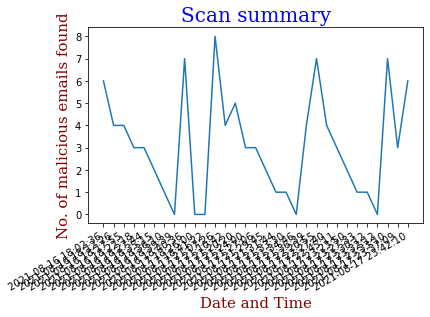

In [16]:
from __future__ import print_function
import cloudmersive_virus_api_client
from cloudmersive_virus_api_client.rest import ApiException
import cloudmersive_validate_api_client
from cloudmersive_validate_api_client.rest import ApiException
from pprint import pprint
from collections import UserList
import tkinter as tk
from tkinter import ttk
from tkinter import *
from tkinter.constants import END, W
import pandas
import win32com.client
import imaplib
import email
from email.header import decode_header
import webbrowser
import os
import sys
import requests
import time
import json
#from tldextract import tldextract
#import joblib
#import pyfiglet
import datetime
import pytz
import numpy as np
import matplotlib.pyplot as plt
import re
import io



timenow = datetime.datetime.now(pytz.timezone('Asia/Singapore'))

col_list = ["url"]
df = pandas.read_csv('malicious.csv', usecols=col_list)

API_key = '9a620234276d322d185e00b59e25242ec06464b994c556d392d2ded861f2e9fe'
url = 'https://www.virustotal.com/vtapi/v2/url/report'
parameters = {'apikey': API_key, 'resource': df}
response= requests.get(url=url, params=parameters)
json_response= json.loads(response.text)

# Connect to inbox
username = 'tpmpuser123@gmail.com'
password = 'Tp@mpuser999'
mail_server = 'imap.gmail.com'
imap_server = imaplib.IMAP4_SSL(host=mail_server)
imap_server.login(username, password)
imap_server.select('Inbox')  # Default is `INBOX`

search_criteria = 'ALL'
charset = None  # All
respose_code, message_numbers_raw = imap_server.search(charset, search_criteria)
message_numbers = message_numbers_raw[0].split()


class Application(tk.Frame):
    def __init__(self, master=None):
        super().__init__(master)
        self.master = master
        self.pack()        
        self.create_widgets()

    def create_widgets(self):
        paddings = {'padx': 5, 'pady': 5 }
        self.fullEmailScanner = tk.Button(self,**paddings)
        self.fullEmailScanner["text"]= "Scan Full Email"
        self.fullEmailScanner["command"] = self.onload
        self.fullEmailScanner.grid(column=0 ,row=1)

        self.urlScanner = tk.Button(self,**paddings)
        self.urlScanner["text"]= "Scan URL Only"
        self.urlScanner["command"] = self.scanner
        self.urlScanner.grid(column=1 ,row=1)

        self.quit = tk.Button(self, text="QUIT", fg="red",command=self.master.destroy,**paddings)
        self.quit.grid(column=2 ,row= 1)       

    def onload(self):
        newWindow = tk.Toplevel(root)
        newWindow.geometry('700x400')
        newWindow.title("KoiScanner Results")
        newWindow01 = tk.Toplevel(root)
        newWindow01.geometry('700x400')
        newWindow01.title("Email attachment scan")
        maliciouslinks= tk.Listbox(newWindow,width=100,height=20)
        maliciousattachment= tk.Listbox(newWindow01,width=100,height=20)
        paddings = {'padx': 5, 'pady': 5}
        numberofcountedmail = 0
        for message_number in message_numbers:
            response_code, message_data = imap_server.fetch(message_number, '(RFC822)')
            for response in message_data:
                #print(response)
                if isinstance(response, tuple):
                    # parse a bytes email into a message object
                    msg = email.message_from_bytes(response[1])
                    subject = msg.get("Subject", None)
                    getFrom = msg.get("From", None)
                    getTo = msg.get("To", None)
                    getDate = msg.get("Date", None)
                    getID = msg.get("Message-ID", None)
                    getSPF = msg.get("Received-SPF", None)
                    getSPFIP = re.search(r"(?:(?:1\d\d|2[0-5][0-5]|2[0-4]\d|0?[1-9]\d|0?0?\d)\.){3}(?:1\d\d|2[0-5][0-5]|2[0-4]\d|0?[1-9]\d|0?0?\d)", getSPF)
                    try:
                        getSPFIPmatch = getSPFIP[0]
                    except TypeError:
                        pass    
                    #getFrom = getFrom.split()
                    #getFrom = getFrom[-1].strip('<>')
                    returnPath = msg.get("Return-Path", None)
                    returnPath = returnPath.strip('<>')
                    receivedSPF = msg.get("Received-SPF", None).split()
                    
                    # if the email message is multipart
                    if msg.is_multipart():
                        # iterate over email parts
                        for part in msg.walk():
                            # extract content type of email
                            content_type = part.get_content_type()
                            content_disposition = str(part.get("Content-Disposition"))
                            try:
                                # get the email body
                                body = part.get_payload(decode=True).decode()
                            except:
                                pass
                            if "attachment" in content_disposition:
                                # download attachment
                                filename = part.get_filename()
                                print(filename)
                                if filename:
                                    folder_name = getID[4:-1]
                                    folder_namereplace1 = folder_name.replace(".", "_")
                                    folder_namereplace2 = folder_namereplace1.replace("@", "_")
                                    if not os.path.isdir(folder_namereplace2):
                                        # make a folder for this email (named after getID)
                                        os.mkdir(folder_namereplace2)
                                    filepath = os.path.join(folder_namereplace2, filename)
                                    # download attachment and save it
                                    open(filepath, "wb").write(part.get_payload(decode=True))
                                    
                                    # Configure API key authorization: Apikey
                                    configuration = cloudmersive_virus_api_client.Configuration()
                                    configuration.api_key['Apikey'] = '1311d233-a957-42d4-9be7-1e166a175845'

                                    # create an instance of the API class
                                    api_instance = cloudmersive_virus_api_client.ScanApi(cloudmersive_virus_api_client.ApiClient(configuration))
                                    input_file = folder_namereplace2+'/'+filename # file | Input file to perform the operation on.
                                    allow_executables = True # bool | Set to false to block executable files (program code) from being allowed in the input file.  Default is false (recommended). (optional)
                                    allow_invalid_files = True # bool | Set to false to block invalid files, such as a PDF file that is not really a valid PDF file, or a Word Document that is not a valid Word Document.  Default is false (recommended). (optional)
                                    allow_scripts = True # bool | Set to false to block script files, such as a PHP files, Python scripts, and other malicious content or security threats that can be embedded in the file.  Set to true to allow these file types.  Default is false (recommended). (optional)
                                    allow_password_protected_files = True # bool | Set to false to block password protected and encrypted files, such as encrypted zip and rar files, and other files that seek to circumvent scanning through passwords.  Set to true to allow these file types.  Default is false (recommended). (optional)
                                    allow_macros = True # bool | Set to false to block macros and other threats embedded in document files, such as Word, Excel and PowerPoint embedded Macros, and other files that contain embedded content threats.  Set to true to allow these file types.  Default is false (recommended). (optional)
                                    allow_xml_external_entities = True # bool | Set to false to block XML External Entities and other threats embedded in XML files, and other files that contain embedded content threats.  Set to true to allow these file types.  Default is false (recommended). (optional)
                                    #restrict_file_types = 'restrict_file_types_example' # str | Specify a restricted set of file formats to allow as clean as a comma-separated list of file formats, such as .pdf,.docx,.png would allow only PDF, PNG and Word document files.  All files must pass content verification against this list of file formats, if they do not, then the result will be returned as CleanResult=false.  Set restrictFileTypes parameter to null or empty string to disable; default is disabled. (optional)
                                    
                                    try:
                                        # Advanced Scan a file for viruses
                                        api_responses = api_instance.scan_file_advanced(input_file, allow_executables=allow_executables, allow_invalid_files=allow_invalid_files, allow_scripts=allow_scripts, allow_password_protected_files=allow_password_protected_files, allow_macros=allow_macros, allow_xml_external_entities=allow_xml_external_entities)
                                        api_response = {}
                                        for x in str(api_responses).split(","):
                                            api_response[x.split(": ")[0].split("'")[1]] = x.split(": ")[1]
                                        if api_response['clean_result'] == 'True':
                                            attachmentclean = "The attachment is clean"
                                        else:
                                            attachmentclean = "The attachment contained viruses!"
                                        if api_response['contains_executable'] == 'False':
                                            attachmentexecutable = "The attachment does not contain any executable"
                                        else:
                                            attachmentexecutable = "The attachment contained an executable"
                                        if api_response['contains_invalid_file'] == 'False':
                                            attachmentinvalid = "The attachment does not contain any invalid file"
                                        else:
                                            attachmentinvalid = "The attachment contained an invalid file!"
                                        if api_response['contains_macros'] == 'False':
                                            attachmentmacros = "The attachment contains no embedded Macros of other embedded threats"
                                        else:
                                            attachmentmacros = "The attachment contained embedded Macros of other embedded threats!"
                                        if api_response['contains_password_protected_file'] == 'False':
                                            attachmentprotected = "The attachment does not contain a password protected or encrypted file"
                                        else:
                                            attachmentprotected = "The attachment contained a password protected or encrypted file!"
                                        if api_response['contains_xml_external_entities'] == 'False':
                                            attachmentxml = "The attachment does not contain embedded XML External Entity threats"
                                        else:
                                            attachmentxml = "The attachment contains embedded XML External Entity threats!"
                                        if api_response['found_viruses'] == 'None':
                                            attachmentviruses = "The attachment contained no viruses"
                                        else:
                                            attachmentviruses = "The attachment contained viruses!"+api_response['found_viruses']
                                        maliciousattachmentdict = {
                                        "IP-Address:": getSPFIPmatch,
                                        "Subject:": subject,
                                        "From:": getFrom,
                                        "To:": getTo,
                                        "Date:": getDate,
                                        "Result:": attachmentclean,
                                        "Executable:": attachmentexecutable,
                                        "Invalid:": attachmentinvalid,
                                        "Macros:": attachmentmacros,
                                        "Password-protected-file:": attachmentprotected,
                                        "XML:": attachmentxml,
                                        "Viruses:": attachmentviruses,
                                        "===========================": "="
                                        }
                                        for key2, value2 in maliciousattachmentdict.items(): 
                                            maliciousattachmentdict = (key2, value2)
                                            maliciousattachment.insert(END,maliciousattachmentdict)
                                    except ApiException as e:
                                        print("Exception when calling ScanApi->scan_file_advanced: %s\n" % e)
                                    
                            #elif content_type == "text/plain" in content_disposition:
                            elif content_type == "text/plain" and "attachment" not in content_disposition:
                                for link in df["url"]:
                                    for letters in body.split():
                                        if link == letters:
                                            #VirusTotal API
                                            parameters = {'apikey': API_key, 'resource': link} #VirusTotal only can check each link
                                            response= requests.get(url=url, params=parameters) # 4 times per minute!
                                                
                                            if response.text == None or response.text == '':
                                                pass
                                            else:
                                                json_response = json.loads(response.text)
                                                if json_response['response_code'] <= 0:
                                                    getstatus = "empty"
                                                elif json_response['response_code'] >= 1:
                                                    if json_response['positives'] <= 0:
                                                        getstatus = "positive"
                                                    else:
                                                        numofpositivescan = json_response['positives']
                                                        
                                                        # Configure API key authorization: Apikey
                                                        configuration = cloudmersive_validate_api_client.Configuration()
                                                        configuration.api_key['Apikey'] = '1311d233-a957-42d4-9be7-1e166a175845'

                                                        # create an instance of the API class
                                                        api_instance12 = cloudmersive_validate_api_client.IPAddressApi(cloudmersive_validate_api_client.ApiClient(configuration))
                                                        ipvalue = str(getSPFIP) # str | IP address to process, e.g. \"55.55.55.55\".  The input is a string so be sure to enclose it in double-quotes.
                                                        #ipvalue = str("2a01:4f8:251:657::2") #can use IPv6
                                                        try:
                                                            # Get intelligence on an IP address
                                                            api_response1 = api_instance12.i_p_address_ip_intelligence(ipvalue)
                                                            pprint(api_response1)
                                                            api_response_check_ip = {}
                                                            for check_ip_sender in str(api_response1).split(","):
                                                                api_response_check_ip[check_ip_sender.split(": ")[0].split("'")[1]] = check_ip_sender.split(": ")[1]
                                                            if api_response_check_ip['is_bot'] == 'False':
                                                                senderipbot = "The sender is not a bot!"
                                                            else:
                                                                senderipbot = "The sender is a bot!"
                                                            if api_response_check_ip['is_threat'] == 'False':
                                                                senderipthreat = "The sender IP address is not a known threat"
                                                            else:
                                                                senderipthreat = "The sender IP address is a known threat!"
                                                            if api_response_check_ip['is_tor_node'] == 'False':
                                                                senderiptor = "The sender IP is not a known Tor exit node which enables anonymous communication"
                                                            else:
                                                                senderiptor = "The sender IP is a known Tor exit node which enables anonymous communication!"
                                                            if api_response_check_ip['location'] == 'None':
                                                                senderiplocation = "The sender IP does not seem to have a location"
                                                            else:
                                                                senderiplocation = "The sender IP address has a location: "+api_response_check_ip['location']
                                                            if api_response_check_ip['region_area'] == 'None':
                                                                senderipregion = "The sender IP does not seem to have a region area"
                                                            else:
                                                                senderipregion = "The sender IP address region area: "+api_response_check_ip['region_area']
                                                            if api_response_check_ip['subregion_area'] == 'None':
                                                                senderipsubregion = "The sender IP does not seem to have a subregion area"
                                                            else:
                                                                senderipsubregion = "The sender IP address subregion area: "+api_response_check_ip['subregion_area']
                                                        except ApiException as e:
                                                            print("Exception when calling IPAddressApi->i_p_address_ip_intelligence: %s\n" % e)   
                                                        maliciousemaildict = {
                                                        "======================Email scanned log=======================": "=",
                                                        "Message-ID:": getID,
                                                        "SPF:": receivedSPF[0],
                                                        "IP-Address:": getSPFIPmatch,
                                                        "Subject:": subject,
                                                        "From:": getFrom,
                                                        "To:": getTo,
                                                        "Date:": getDate,
                                                        "Malicious-link:": letters,
                                                        "Number-of-websites-scanned-as-malicious-out-of-89-websites": numofpositivescan,
                                                        "======================Sender's IP address log=======================": "=",
                                                        "Sender-IP-Bot:": senderipbot,
                                                        "Sender-IP-Threat:": senderipthreat,
                                                        "Sender-IP-Tor:": senderiptor,
                                                        "Sender-IP-Location:": senderiplocation,
                                                        "Sender-IP-Region:": senderipregion,
                                                        "Sender-IP-Subregion:": senderipsubregion,
                                                        " ": " ",
                                                        " ": " "
                                                        }
                                                        for key1, value1 in maliciousemaildict.items(): 
                                                            maliciousemaildictprint = (key1, value1)
                                                            maliciouslinks.insert(END,maliciousemaildictprint)
                                                        imap_server.create('malicious')
                                                        imap_server.store(message_number, '+X-GM-LABELS', 'malicious')
                                                        imap_server.store(message_number, '+FLAGS', '\Deleted')  # read mail remove from inbox
                                                        imap_server.expunge() 
                                                        numberofcountedmail += 1
                                                        logemails = []
                                                        loggeddata = [getID, receivedSPF[0], getSPFIPmatch, subject, getFrom, getTo, getDate, letters]
                                                        logemails.append(loggeddata)
                                                        logdf = pandas.DataFrame(logemails, columns = ['messageid', 'spf', 'ipadd', 'subject', 'from', 'to', 'date', 'maliciouslink'])
                                                        logdf.to_csv("emaillogs.csv", mode = 'a', header = False, index = False)
                                        elif receivedSPF[0] != "pass":
                                            imap_server.create('malicious')
                                            imap_server.store(message_number, '+X-GM-LABELS', 'malicious')
                                            imap_server.store(message_number, '+FLAGS', '\Deleted')  # read mail remove from inbox
                                            imap_server.expunge()
                                            print("Subject:", subject)
                                            print("From:", getFrom)
                                            print("SPF Status:", receivedSPF[0], ". Not secure.")
                                        else:
                                            continue
                            
        #Start of the codes for the graph                    
        scanResult = []
        scannedEmails = numberofcountedmail
        dateAndTimeNow = timenow.strftime('%Y-%m-%d %H:%M:%S')
        scanneddata = [scannedEmails, dateAndTimeNow]
        scanResult.append(scanneddata)
        df2 = pandas.DataFrame(scanResult, columns = ['numberscan', 'dnt'])
        df2.to_csv("scanemail.csv", mode = 'a', header = False, index = False)

        df2headers = ['numberscan', 'dnt']
        readdf2 = pandas.read_csv("scanemail.csv", usecols=df2headers)
        x = readdf2['dnt']
        y = readdf2['numberscan']

        font1 = {'family':'serif','color':'blue','size':20}
        font2 = {'family':'serif','color':'darkred','size':15}

        plt.title("Scan summary", fontdict = font1)
        plt.xlabel("Date and Time", fontdict = font2)
        plt.ylabel("No. of malicious emails found", fontdict = font2)
        plt.locator_params(axis="both", integer=True, tight=True)

        # plot
        plt.plot(x,y)
        # beautify the x-labels
        plt.gcf().autofmt_xdate()
        plt.show()
        #End of codes for the graph            
        
        Displaytext2 = tk.Label(newWindow, text="The Following Links are malicious according to VirusTotal !",**paddings)
        Displaytext2.pack()
        maliciouslinks.pack()
        Displaytext01 = tk.Label(newWindow01, text="The following email attachments scan results according to Cloudmersive!",**paddings)
        Displaytext01.pack()
        maliciousattachment.pack()

        imap_server.close()
        imap_server.logout()

    def scanner(self):
        
        newWindow2 = tk.Toplevel(root)
        newWindow2.geometry('400x230')
        newWindow2.title("KoiScanner for URL Link")

        def scan_url():
            results_scanner = "False"

            urltoscan = user_input.get()
            for link in df["url"]:
                for letters in urltoscan.split():
                    if link == letters:
                        parameters = {'apikey': API_key, 'resource': link} #VirusTotal only can check each link
                        response= requests.get(url=url, params=parameters) # 4 times per minute!
                        json_response = json.loads(response.text)
                        if json_response['response_code'] <= 0:
                            getstatus = "empty"
                        elif json_response['response_code'] >= 1:
                            if json_response['positives'] <= 0:
                                getstatus = "positive"
                            else:
                                getstatus = "malicious"
                                if getstatus == "malicious":
                                    results_scanner="True"

            newWindow3 = tk.Toplevel(newWindow2)
            newWindow3.geometry('400x230')
            newWindow3.title("KoiScanner for URL Link RESULTS")

            if results_scanner == "True":
                tk.Label(newWindow3, text="The Link IS Malicious").pack()
            else:
                tk.Label(newWindow3, text="The Link is NOT Malicious").pack()
            tk.Button(newWindow3, text="QUIT", fg="red",command=newWindow3.destroy).pack()

        tk.Label(newWindow2, text="Please Enter the Link Below!").pack()
        user_input = tk.StringVar(newWindow2)
        entry = tk.Entry(newWindow2, textvariable=user_input).pack()
        button1 = tk.Button(newWindow2,text='Scan the URL', command=scan_url).pack()
        
        tk.Button(newWindow2, text="QUIT", fg="red",command=newWindow2.destroy).pack()
  

    def exit(self):
        root.destroy()


root = tk.Tk()
root.title("KoiScanner")
root.geometry('400x230')
#bg = tk.PhotoImage(file = "D:/School Stuff/STI/KoiScanner/images/title_logo2.png")
#canvas1 = tk.Canvas( root, width = 300, height = 100)  
#canvas1.pack(fill = "both", expand = True)
#canvas1.create_image( 0, 0, image = bg,anchor = "nw")


app = Application(master=root)
app.mainloop()

####today

test.py
Subject: Hello from the president!
From: "Joe Biden" <joebiden@whitehouse.gov>
SPF Status: softfail . Not secure.
To: tpmpuser123@gmail.com
Date: Wed, 18 Aug 2021 16:54:23 +0200 (CEST)
ID <20210818145423.D4FB42414F@emkei.cz>
SPF: softfail (google.com: domain of transitioning joebiden@whitehouse.gov does not designate 101.99.94.155 as permitted sender) client-ip=101.99.94.155;
https://ipqualityscore.com/api/json/url/HBeGUqOl06l3B3jcN62aIFzSiwyqFfYn/https%3A%2F%2Frakuten.card%2D2r.club%2Fl
{'message': 'Success.', 'success': True, 'unsafe': True, 'domain': 'rakuten.card-2r.club', 'server': 'N/A', 'content_type': '', 'status_code': 0, 'page_size': 0, 'domain_rank': 0, 'dns_valid': False, 'parking': True, 'spamming': True, 'malware': True, 'phishing': True, 'suspicious': True, 'adult': False, 'risk_score': 100, 'category': 'Phishing', 'domain_age': {'human': '1 month ago', 'timestamp': 1626703240, 'iso': '2021-07-19T10:00:40-04:00'}, 'request_id': '4DrwoZN8LAeDWsA'}
True
True
True
h

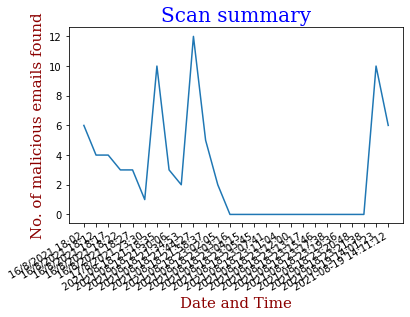

In [ ]:
from __future__ import print_function
import cloudmersive_virus_api_client
from cloudmersive_virus_api_client.rest import ApiException
import cloudmersive_validate_api_client
from cloudmersive_validate_api_client.rest import ApiException
from pprint import pprint
from collections import UserList
import tkinter as tk
from tkinter import ttk
from tkinter import *
from tkinter.constants import END, W
import pandas
import win32com.client
import imaplib
import email
from email.header import decode_header
import webbrowser
import os
import sys
import requests
import time
import json
#from tldextract import tldextract
#import joblib
#import pyfiglet
import datetime
import pytz
import numpy as np
import matplotlib.pyplot as plt
import re
import io
import webbrowser
import urllib.parse
from urllib.error import HTTPError

timenow = datetime.datetime.now(pytz.timezone('Asia/Singapore'))

col_list = ["url"]
df = pandas.read_csv('malicious.csv', usecols=col_list)

API_key = '9a620234276d322d185e00b59e25242ec06464b994c556d392d2ded861f2e9fe'
url = 'https://www.virustotal.com/vtapi/v2/url/report'
parameters = {'apikey': API_key, 'resource': df}
response= requests.get(url=url, params=parameters)
json_response= json.loads(response.text)

# Connect to inbox
username = 'tpmpuser123@gmail.com'
password = 'Tp@mpuser999'
mail_server = 'imap.gmail.com'
imap_server = imaplib.IMAP4_SSL(host=mail_server)
imap_server.login(username, password)
imap_server.select('Inbox')  # Default is `INBOX`

search_criteria = 'ALL'
charset = None  # All
respose_code, message_numbers_raw = imap_server.search(charset, search_criteria)
message_numbers = message_numbers_raw[0].split()


class Application(tk.Frame):
    def __init__(self, master=None):
        super().__init__(master)
        self.master = master
        self.pack()        
        self.create_widgets()

    def create_widgets(self):
        paddings = {'padx': 5, 'pady': 5 }
        self.fullEmailScanner = tk.Button(self,**paddings)
        self.fullEmailScanner["text"]= "Scan Full Email"
        self.fullEmailScanner["command"] = self.onload
        self.fullEmailScanner.grid(column=0 ,row=1)

        self.urlScanner = tk.Button(self,**paddings)
        self.urlScanner["text"]= "Scan URL Only"
        self.urlScanner["command"] = self.scanner
        self.urlScanner.grid(column=1 ,row=1)

        self.quit = tk.Button(self, text="QUIT", fg="red",command=self.master.destroy,**paddings)
        self.quit.grid(column=2 ,row= 1)       

    def onload(self):
        newWindow = tk.Toplevel(root)
        newWindow.geometry('800x500')
        newWindow.title("KoiScanner Results")
        newWindow01 = tk.Toplevel(root)
        newWindow01.geometry('700x400')
        newWindow01.title("Email attachment scan")
        maliciouslinks= tk.Listbox(newWindow,width=200,height=40)
        maliciousattachment= tk.Listbox(newWindow01,width=100,height=20)
        paddings = {'padx': 5, 'pady': 5}
        numberofcountedmail = 0
        for message_number in message_numbers:
            response_code, message_data = imap_server.fetch(message_number, '(RFC822)')
            for response in message_data:
                #print(response)
                if isinstance(response, tuple):
                    # parse a bytes email into a message object
                    msg = email.message_from_bytes(response[1])
                    subject = msg.get("Subject", None)
                    getFrom = msg.get("From", None)
                    getTo = msg.get("To", None)
                    getDate = msg.get("Date", None)
                    getID = msg.get("Message-ID", None)
                    getSPF = msg.get("Received-SPF", None)
                    getSPFIP = re.search(r"(?:(?:1\d\d|2[0-5][0-5]|2[0-4]\d|0?[1-9]\d|0?0?\d)\.){3}(?:1\d\d|2[0-5][0-5]|2[0-4]\d|0?[1-9]\d|0?0?\d)", getSPF)
                    try:
                        getSPFIPmatch = getSPFIP[0]
                    except TypeError:
                        pass    
                    returnPath = msg.get("Return-Path", None)
                    returnPath = returnPath.strip('<>')
                    receivedSPF = msg.get("Received-SPF", None).split()
                    
                    # if the email message is multipart
                    if msg.is_multipart():
                        # iterate over email parts
                        for part in msg.walk():
                            # extract content type of email
                            content_type = part.get_content_type()
                            content_disposition = str(part.get("Content-Disposition"))
                            try:
                                # get the email body
                                body = part.get_payload(decode=True).decode()
                            except:
                                pass
                            if "attachment" in content_disposition:
                                # download attachment
                                filename = part.get_filename()
                                print(filename)
                                if filename:
                                    folder_name = getID[4:-1]
                                    folder_namereplace1 = folder_name.replace(".", "_")
                                    folder_namereplace2 = folder_namereplace1.replace("@", "_")
                                    if not os.path.isdir(folder_namereplace2):
                                        # make a folder for this email (named after getID)
                                        os.mkdir(folder_namereplace2)
                                    filepath = os.path.join(folder_namereplace2, filename)
                                    # download attachment and save it
                                    open(filepath, "wb").write(part.get_payload(decode=True))
                                    
                                    # Configure API key authorization: Apikey
                                    configuration = cloudmersive_virus_api_client.Configuration()
                                    configuration.api_key['Apikey'] = '02be95ce-7b88-4886-8edc-3d7df7371dbf'

                                    # create an instance of the API class
                                    api_instance = cloudmersive_virus_api_client.ScanApi(cloudmersive_virus_api_client.ApiClient(configuration))
                                    input_file = folder_namereplace2+'/'+filename # file | Input file to perform the operation on.
                                    allow_executables = True # bool | Set to false to block executable files (program code) from being allowed in the input file.  Default is false (recommended). (optional)
                                    allow_invalid_files = True # bool | Set to false to block invalid files, such as a PDF file that is not really a valid PDF file, or a Word Document that is not a valid Word Document.  Default is false (recommended). (optional)
                                    allow_scripts = True # bool | Set to false to block script files, such as a PHP files, Python scripts, and other malicious content or security threats that can be embedded in the file.  Set to true to allow these file types.  Default is false (recommended). (optional)
                                    allow_password_protected_files = True # bool | Set to false to block password protected and encrypted files, such as encrypted zip and rar files, and other files that seek to circumvent scanning through passwords.  Set to true to allow these file types.  Default is false (recommended). (optional)
                                    allow_macros = True # bool | Set to false to block macros and other threats embedded in document files, such as Word, Excel and PowerPoint embedded Macros, and other files that contain embedded content threats.  Set to true to allow these file types.  Default is false (recommended). (optional)
                                    allow_xml_external_entities = True # bool | Set to false to block XML External Entities and other threats embedded in XML files, and other files that contain embedded content threats.  Set to true to allow these file types.  Default is false (recommended). (optional)
                                    #restrict_file_types = 'restrict_file_types_example' # str | Specify a restricted set of file formats to allow as clean as a comma-separated list of file formats, such as .pdf,.docx,.png would allow only PDF, PNG and Word document files.  All files must pass content verification against this list of file formats, if they do not, then the result will be returned as CleanResult=false.  Set restrictFileTypes parameter to null or empty string to disable; default is disabled. (optional)
                                    
                                    try:
                                        # Advanced Scan a file for viruses
                                        api_responses = api_instance.scan_file_advanced(input_file, allow_executables=allow_executables, allow_invalid_files=allow_invalid_files, allow_scripts=allow_scripts, allow_password_protected_files=allow_password_protected_files, allow_macros=allow_macros, allow_xml_external_entities=allow_xml_external_entities)
                                        api_response = {}
                                        for x in str(api_responses).split(","):
                                            api_response[x.split(": ")[0].split("'")[1]] = x.split(": ")[1]
                                        if api_response['clean_result'] == 'True':
                                            attachmentclean = "The attachment is clean"
                                        else:
                                            attachmentclean = "The attachment contained viruses!"
                                        if api_response['contains_executable'] == 'False':
                                            attachmentexecutable = "The attachment does not contain any executable"
                                        else:
                                            attachmentexecutable = "The attachment contained an executable"
                                        if api_response['contains_invalid_file'] == 'False':
                                            attachmentinvalid = "The attachment does not contain any invalid file"
                                        else:
                                            attachmentinvalid = "The attachment contained an invalid file!"
                                        if api_response['contains_macros'] == 'False':
                                            attachmentmacros = "The attachment contains no embedded Macros of other embedded threats"
                                        else:
                                            attachmentmacros = "The attachment contained embedded Macros of other embedded threats!"
                                        if api_response['contains_password_protected_file'] == 'False':
                                            attachmentprotected = "The attachment does not contain a password protected or encrypted file"
                                        else:
                                            attachmentprotected = "The attachment contained a password protected or encrypted file!"
                                        if api_response['contains_xml_external_entities'] == 'False':
                                            attachmentxml = "The attachment does not contain embedded XML External Entity threats"
                                        else:
                                            attachmentxml = "The attachment contains embedded XML External Entity threats!"
                                        if api_response['found_viruses'] == 'None':
                                            attachmentviruses = "The attachment contained no viruses"
                                        else:
                                            attachmentviruses = "The attachment contained viruses!"+api_response['found_viruses']
                                        maliciousattachmentdict = {
                                        "IP-Address:": getSPFIPmatch,
                                        "Subject:": subject,
                                        "From:": getFrom,
                                        "To:": getTo,
                                        "Date:": getDate,
                                        "Result:": attachmentclean,
                                        "Executable:": attachmentexecutable,
                                        "Invalid:": attachmentinvalid,
                                        "Macros:": attachmentmacros,
                                        "Password-protected-file:": attachmentprotected,
                                        "XML:": attachmentxml,
                                        "Viruses:": attachmentviruses,
                                        "===========================": "="
                                        }
                                        for key2, value2 in maliciousattachmentdict.items(): 
                                            maliciousattachmentdict = (key2, value2)
                                            maliciousattachment.insert(END,maliciousattachmentdict)
                                    except ApiException as e:
                                        print("Exception when calling ScanApi->scan_file_advanced: %s\n" % e)
                                    
                            #elif content_type == "text/plain" in content_disposition:
                            elif content_type == "text/plain" and "attachment" not in content_disposition:
                                for link in df["url"]:
                                    for letters in body.split():
                                        if link == letters:
                                            #VirusTotal API
                                            parameters = {'apikey': API_key, 'resource': link} #VirusTotal only can check each link
                                            response= requests.get(url=url, params=parameters) # 4 times per minute!
                                                
                                            if response.text == None or response.text == '':
                                                pass
                                            else:
                                                json_response = json.loads(response.text)
                                                if json_response['response_code'] <= 0:
                                                    getstatus = "empty"
                                                elif json_response['response_code'] >= 1:
                                                    if json_response['positives'] <= 0:
                                                        getstatus = "positive"
                                                    else:
                                                        numofpositivescan = json_response['positives']
                                                        
                                                        # Use Cloudmersive API
                                                        configuration = cloudmersive_validate_api_client.Configuration()
                                                        configuration.api_key['Apikey'] = '02be95ce-7b88-4886-8edc-3d7df7371dbf'

                                                        # create an instance of the API class
                                                        api_instance12 = cloudmersive_validate_api_client.IPAddressApi(cloudmersive_validate_api_client.ApiClient(configuration))
                                                        ipvalue = str(getSPFIP) # str | IP address to process, e.g. \"55.55.55.55\".  The input is a string so be sure to enclose it in double-quotes.
                                                        #ipvalue = str("2a01:4f8:251:657::2") #can use IPv6
                                                        try:
                                                            # Get intelligence on an IP address
                                                            api_response1 = api_instance12.i_p_address_ip_intelligence(ipvalue)
                                                            #pprint(api_response1)
                                                            api_response_check_ip = {}
                                                            for check_ip_sender in str(api_response1).split(","):
                                                                api_response_check_ip[check_ip_sender.split(": ")[0].split("'")[1]] = check_ip_sender.split(": ")[1]
                                                            if api_response_check_ip['is_bot'] == 'False':
                                                                senderipbot = "The sender is not a bot!"
                                                            else:
                                                                senderipbot = "The sender is a bot!"
                                                            if api_response_check_ip['is_threat'] == 'False':
                                                                senderipthreat = "The sender IP address is not a known threat"
                                                            else:
                                                                senderipthreat = "The sender IP address is a known threat!"
                                                            if api_response_check_ip['is_tor_node'] == 'False':
                                                                senderiptor = "The sender IP is not a known Tor exit node which enables anonymous communication"
                                                            else:
                                                                senderiptor = "The sender IP is a known Tor exit node which enables anonymous communication!"
                                                            if api_response_check_ip['location'] == 'None':
                                                                senderiplocation = "The sender IP does not seem to have a location"
                                                            else:
                                                                senderiplocation = "The sender IP address has a location: "+api_response_check_ip['location']
                                                            if api_response_check_ip['region_area'] == 'None':
                                                                senderipregion = "The sender IP does not seem to have a region area"
                                                            else:
                                                                senderipregion = "The sender IP address region area: "+api_response_check_ip['region_area']
                                                            if api_response_check_ip['subregion_area'] == 'None':
                                                                senderipsubregion = "The sender IP does not seem to have a subregion area"
                                                            else:
                                                                senderipsubregion = "The sender IP address subregion area: "+api_response_check_ip['subregion_area']
                                                        except ApiException as e:
                                                            print("Exception when calling IPAddressApi->i_p_address_ip_intelligence: %s\n" % e)   
                                                        
                                                        #Use ipqualityscore API
                                                        ipqualityscorescan = str(link)
                                                        ipqualityscorescan = ipqualityscorescan.replace(':', '%3A')
                                                        ipqualityscorescan = ipqualityscorescan.replace('/', '%2F')
                                                        ipqualityscorescan = ipqualityscorescan.replace(' ', '%20')
                                                        ipqualityscorescan = ipqualityscorescan.replace('~', '%7E')
                                                        ipqualityscorescan = ipqualityscorescan.replace('-', '%2D')
                                                        ipqualityapi_key = "HBeGUqOl06l3B3jcN62aIFzSiwyqFfYn"
                                                        ipqualityscorescan1 = "https://ipqualityscore.com/api/json/url/"+ipqualityapi_key+"/"+ipqualityscorescan
                                                        print(ipqualityscorescan1)
                                                        with urllib.request.urlopen(ipqualityscorescan1) as urlquality:
                                                            try:
                                                                ipqualitydata = json.loads(urlquality.read().decode())
                                                                print(ipqualitydata)
                                                                print(ipqualitydata['phishing'])
                                                                print(ipqualitydata['malware'])
                                                                print(ipqualitydata['suspicious'])
                                                                if ipqualitydata['unsafe'] == True:
                                                                    ipqualitydataunsafe = "The domain is suspected of being unsafe due to phishing, malware, spamming, or abusive behavior!"
                                                                else:
                                                                    ipqualitydataunsafe = "The domain is clean!"
                                                                ipqualitydataDomain = ipqualitydata['domain']
                                                                ipqualitydataServer = ipqualitydata['server']
                                                                ipqualitydataContenttype = ipqualitydata['content_type']
                                                                if ipqualitydata['status_code'] == 200:
                                                                    ipqualitydataStatuscode = "The domain is a valid website!"
                                                                else:
                                                                    ipqualitydataStatuscode = "The domain is unreachable!"
                                                                if ipqualitydata['dns_valid'] == True:
                                                                    ipqualitydataDNS = "The domain has valid DNS records!"
                                                                else:
                                                                    ipqualitydataDNS = "The domain has no valid DNS records."
                                                                if ipqualitydata['spamming'] == True:
                                                                    ipqualitydataSpamming = "The domain of the malicious URL is associated with email SPAM or abusive email addresses!"
                                                                else:
                                                                    ipqualitydataSpamming = "The domain of the malicious URL is not associated with email SPAM or abusive email addresses!"
                                                                if ipqualitydata['malware'] == True:
                                                                    ipqualitydataMalware = "The malicious URL is associated with malware or viruses!"
                                                                else:
                                                                    ipqualitydataMalware = "The malicious URL is not associated with malware or viruses"
                                                                if ipqualitydata['phishing'] == True:
                                                                    ipqualitydataPhishing = "The malicious URL is associated with malicious phishing behavior!"
                                                                else:
                                                                    ipqualitydataPhishing = "The malicious URL is not associated with malicious phishing behavior"
                                                                if ipqualitydata['suspicious'] == True:
                                                                    ipqualitydataSuspicious = "The malicious URL is suspected of being malicious or used for phishing or abuse!"
                                                                else:
                                                                    ipqualitydataSuspicious = "The malicious URL is not suspected of being malicious or used for phishing or abuse"
                                                                ipqualitydataRiskscore = "The IPQS risk score which estimates the confidence level for malicious URL detection, 85 for high risk, 100 for accurate:"+str(ipqualitydata['risk_score'])
                                                                ipqualitydataCategory = ipqualitydata['category']
                                                                ipqualitydataDomainage = ipqualitydata['domain_age']
                                                            except HTTPError:
                                                                print("Website has been taken down or gone!")
                                                                pass
                                                        
                                                        maliciousemaildict = {
                                                        "======================Email scanned log=======================": "=",
                                                        "Message-ID:": getID,
                                                        "SPF:": receivedSPF[0],
                                                        "IP-Address:": getSPFIPmatch,
                                                        "Subject:": subject,
                                                        "From:": getFrom,
                                                        "To:": getTo,
                                                        "Date:": getDate,
                                                        "Malicious-link:": letters,
                                                        "Number-of-websites-scanned-as-malicious-out-of-89-websites": numofpositivescan,
                                                        "======================Sender's IP address log=======================": "=",
                                                        "Sender-IP-Bot:": senderipbot,
                                                        "Sender-IP-Threat:": senderipthreat,
                                                        "Sender-IP-Tor:": senderiptor,
                                                        "Sender-IP-Location:": senderiplocation,
                                                        "Sender-IP-Region:": senderipregion,
                                                        "Sender-IP-Subregion:": senderipsubregion,
                                                        "======================Malicious Domain log=======================": "=",
                                                        "Safe/Unsafe-Domain:": ipqualitydataunsafe,
                                                        "Domain-Name:": ipqualitydataDomain,
                                                        "Server:": ipqualitydataServer,
                                                        "MIME-Content-type:": ipqualitydataContenttype,
                                                        "Status-Code:": ipqualitydataStatuscode,
                                                        "DNS-Records:": ipqualitydataDNS,
                                                        "Spamming:": ipqualitydataSpamming,
                                                        "Malware:": ipqualitydataMalware,
                                                        "Phishing:": ipqualitydataPhishing,
                                                        "Suspicious:": ipqualitydataSuspicious,
                                                        "Risk-Score:": ipqualitydataRiskscore,
                                                        "Category:": ipqualitydataCategory,
                                                        "Domain-Age:": ipqualitydataDomainage,
                                                        " ": " ",
                                                        " ": " "
                                                        }
                                                        for key1, value1 in maliciousemaildict.items(): 
                                                            maliciousemaildictprint = (key1, value1)
                                                            maliciouslinks.insert(END,maliciousemaildictprint)
                                                        imap_server.create('malicious')
                                                        imap_server.store(message_number, '+X-GM-LABELS', 'malicious')
                                                        imap_server.store(message_number, '+FLAGS', '\Deleted')  # read mail remove from inbox
                                                        imap_server.expunge() 
                                                        numberofcountedmail += 1
                                                        #logemails = []
                                                        #loggeddata = [getID, receivedSPF[0], getSPFIPmatch, subject, getFrom, getTo, getDate, letters]
                                                        #logemails.append(loggeddata)
                                                        #logdf = pandas.DataFrame(logemails, columns = ['messageid', 'spf', 'ipadd', 'subject', 'from', 'to', 'date', 'maliciouslink'])
                                                        #logdf.to_csv("emaillogs.csv", mode = 'a', header = False, index = False)
                                                        
                                                        #For sandbox testing environment
                                                        #Must have an account first to test out, API no clue on how to make it work
                                                        urltest = "https://live.browserstack.com/dashboard?try_live_url=https%3A%2F%2Fbtwebbusinesss.weebly.com%2F#os=Windows&os_version=10&browser=Edge&browser_version=92.0&zoom_to_fit=true&full_screen=true&resolution=responsive-mode&url="+link+"&speed=1"
                                                        webbrowser.open(urltest,new=2)
                                                        
                                        elif receivedSPF[0] != "pass":
                                            print("Subject:", subject)
                                            print("From:", getFrom)
                                            print("SPF Status:", receivedSPF[0], ". Not secure.")
                                            print("To:",getTo)
                                            print("Date:",getDate)
                                            print("ID",getID)
                                            print("SPF:",getSPF)
                                            imap_server.create('malicious')
                                            imap_server.store(message_number, '+X-GM-LABELS', 'malicious')
                                            imap_server.store(message_number, '+FLAGS', '\Deleted')  # read mail remove from inbox
                                            imap_server.expunge()
                                        else:
                                            continue
                    else:
                        if receivedSPF[0] != "pass":
                            print("Subject:", subject)
                            print("From:", getFrom)
                            print("SPF Status:", receivedSPF[0], ". Not secure.")
                            print("To:",getTo)
                            print("Date:",getDate)
                            print("ID",getID)
                            print("SPF:",getSPF)
                            imap_server.create('malicious')
                            imap_server.store(message_number, '+X-GM-LABELS', 'malicious')
                            imap_server.store(message_number, '+FLAGS', '\Deleted')  # read mail remove from inbox
                            imap_server.expunge()
                        else:
                            continue
        
        #Start of the codes for the graph                    
        scanResult = []
        scannedEmails = numberofcountedmail
        dateAndTimeNow = timenow.strftime('%Y-%m-%d %H:%M:%S')
        scanneddata = [scannedEmails, dateAndTimeNow]
        scanResult.append(scanneddata)
        df2 = pandas.DataFrame(scanResult, columns = ['numberscan', 'dnt'])
        df2.to_csv("scanemail.csv", mode = 'a', header = False, index = False)

        df2headers = ['numberscan', 'dnt']
        readdf2 = pandas.read_csv("scanemail.csv", usecols=df2headers)
        x = readdf2['dnt']
        y = readdf2['numberscan']

        font1 = {'family':'serif','color':'blue','size':20}
        font2 = {'family':'serif','color':'darkred','size':15}

        plt.title("Scan summary", fontdict = font1)
        plt.xlabel("Date and Time", fontdict = font2)
        plt.ylabel("No. of malicious emails found", fontdict = font2)
        plt.locator_params(axis="both", integer=True, tight=True)

        # plot
        plt.plot(x,y)
        # beautify the x-labels
        plt.gcf().autofmt_xdate()
        plt.show()
        #End of codes for the graph            
        
        Displaytext2 = tk.Label(newWindow, text="The Following Links are malicious according to VirusTotal !",**paddings)
        Displaytext2.pack()
        maliciouslinks.pack()
        Displaytext01 = tk.Label(newWindow01, text="The following email attachments scan results according to Cloudmersive!",**paddings)
        Displaytext01.pack()
        maliciousattachment.pack()

        imap_server.close()
        imap_server.logout()

    def scanner(self):
        
        newWindow2 = tk.Toplevel(root)
        newWindow2.geometry('400x230')
        newWindow2.title("KoiScanner for URL Link")

        def scan_url():
            results_scanner = "False"

            urltoscan = user_input.get()
            for link in df["url"]:
                for letters in urltoscan.split():
                    if link == letters:
                        parameters = {'apikey': API_key, 'resource': link} #VirusTotal only can check each link
                        response= requests.get(url=url, params=parameters) # 4 times per minute!
                        json_response = json.loads(response.text)
                        if json_response['response_code'] <= 0:
                            getstatus = "empty"
                        elif json_response['response_code'] >= 1:
                            if json_response['positives'] <= 0:
                                getstatus = "positive"
                            else:
                                getstatus = "malicious"
                                if getstatus == "malicious":
                                    results_scanner="True"

            newWindow3 = tk.Toplevel(newWindow2)
            newWindow3.geometry('400x230')
            newWindow3.title("KoiScanner for URL Link RESULTS")

            if results_scanner == "True":
                tk.Label(newWindow3, text="The Link IS Malicious").pack()
            else:
                tk.Label(newWindow3, text="The Link is NOT Malicious").pack()
            tk.Button(newWindow3, text="QUIT", fg="red",command=newWindow3.destroy).pack()

        tk.Label(newWindow2, text="Please Enter the Link Below!").pack()
        user_input = tk.StringVar(newWindow2)
        entry = tk.Entry(newWindow2, textvariable=user_input).pack()
        button1 = tk.Button(newWindow2,text='Scan the URL', command=scan_url).pack()
        
        tk.Button(newWindow2, text="QUIT", fg="red",command=newWindow2.destroy).pack()
  

    def exit(self):
        root.destroy()


root = tk.Tk()
root.title("KoiScanner")
root.geometry('400x230')
#bg = tk.PhotoImage(file = "D:/School Stuff/STI/KoiScanner/images/title_logo2.png")
#canvas1 = tk.Canvas( root, width = 300, height = 100)  
#canvas1.pack(fill = "both", expand = True)
#canvas1.create_image( 0, 0, image = bg,anchor = "nw")


app = Application(master=root)
app.mainloop()